# Medical transcript classification [sklearn]
* Multiclass classification of medical transcript.
* Reference notebook: <https://www.kaggle.com/code/leekahwin/text-classification-using-n-gram-0-8-f1/notebook>
* Dataset: <https://www.kaggle.com/code/leekahwin/text-classification-using-n-gram-0-8-f1/input>

By running this notebook, you’ll create a whole test suite in a few lines of code. The model used here is a Random Forest classification model with the medical transcript dataset. Feel free to use your own model (tabular, text, or LLM).

You’ll learn how to:

* Detect vulnerabilities by scanning the model
* Generate a test suite with domain-specific tests
* Customize your test suite by loading a test from the Giskard catalog
* Upload your model to the Giskard server to:
    * Compare models to decide which one to promote
    * Debug your tests to diagnose issues
    * Share your results and collect business feedback from your team

## Install Giskard

In [207]:
pip install "giskard>=2.0.0b" -U

  Obtaining dependency information for giskard>=2.0.0b from https://files.pythonhosted.org/packages/ad/60/a2f0581afeb4368acfd165ecdd430adc4dc9f9559ce1caf5873cf7b02613/giskard-2.0.0b14-py3-none-any.whl.metadata
  Using cached giskard-2.0.0b14-py3-none-any.whl.metadata (13 kB)
Using cached giskard-2.0.0b14-py3-none-any.whl (385 kB)
  Attempting uninstall: giskard
    Found existing installation: giskard 2.0.0b12
    Uninstalling giskard-2.0.0b12:
      Successfully uninstalled giskard-2.0.0b12
Note: you may need to restart the kernel to use updated packages.


## Install necessary dependencies

In [208]:
!pip install nltk

## Import libraries

In [209]:
import os
import string
from pathlib import Path
from typing import Iterable
from urllib.request import urlretrieve

import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

import giskard
from giskard import Dataset, Model, GiskardClient, testing

## Download NLTK stopwords corpus

In [210]:
# Download list of english stopwords.
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mathieuroques/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Define constants

In [211]:
# Constants.
LABELS_LIST = [
    'Neurosurgery',
    'ENT - Otolaryngology',
    'Discharge Summary',
    'General Medicine',
    'Gastroenterology',
    'Neurology',
    'SOAP / Chart / Progress Notes',
    'Obstetrics / Gynecology',
    'Urology'
]

TEXT_COLUMN_NAME = "transcription"
TARGET_COLUMN_NAME = "medical_specialty"

RANDOM_SEED = 8888

# Data.
DATA_URL = os.path.join("ftp://sys.giskard.ai", "pub", "unit_test_resources",
                        "medical_transcript_classification_dataset", "mtsamples.csv")
DATA_PATH = Path.home() / ".giskard" / "medical_transcript_classification_dataset" / "mtsamples.csv"

## Dataset preparation

### Load data

In [212]:
def fetch_from_ftp(url: str, file: Path) -> None:
    """Helper to fetch data from the FTP server."""
    if not file.parent.exists():
        file.parent.mkdir(parents=True, exist_ok=True)

    if not file.exists():
        print(f"Downloading data from {url}")
        urlretrieve(url, file)

    print(f"Data was loaded!")


def load_data() -> pd.DataFrame:
    """Load and initially preprocess data."""
    fetch_from_ftp(DATA_URL, DATA_PATH)

    df = pd.read_csv(DATA_PATH)

    # Drop useless columns.
    df = df.drop(columns=['Unnamed: 0', "description", "sample_name", "keywords"])

    # Trim text.
    df = df.apply(lambda x: x.str.strip())

    # Filter samples by label.
    df = df[df[TARGET_COLUMN_NAME].isin(LABELS_LIST)]

    # Drop rows with no transcript.
    df = df[df[TEXT_COLUMN_NAME].notna()]

    return df

In [213]:
transcript_df = load_data()

Data was loaded!


### Train-test split

In [214]:
X_train, X_test, y_train, y_test = train_test_split(transcript_df[[TEXT_COLUMN_NAME]],
                                                    transcript_df[TARGET_COLUMN_NAME],
                                                    random_state=RANDOM_SEED)

### Wrap dataset with Giskard

In [215]:
raw_data = pd.concat([X_test, y_test], axis=1)
wrapped_data = Dataset(raw_data,
                       name="medical_transcript_dataset",
                       target=TARGET_COLUMN_NAME,
                       column_types={TEXT_COLUMN_NAME: "text"})

## Model training

### Define preprocessing steps

In [216]:
stemmer = SnowballStemmer("english")
stop_words = stopwords.words("english")


def preprocess_text(df: pd.DataFrame) -> pd.DataFrame:
    """Preprocess text."""
    # Lower.
    df[TEXT_COLUMN_NAME] = df[TEXT_COLUMN_NAME].apply(lambda x: x.lower())

    # Remove punctuation.
    df[TEXT_COLUMN_NAME] = df[TEXT_COLUMN_NAME].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

    # Tokenize.
    df[TEXT_COLUMN_NAME] = df[TEXT_COLUMN_NAME].apply(lambda x: x.split())

    # Stem.
    df[TEXT_COLUMN_NAME] = df[TEXT_COLUMN_NAME].apply(lambda x: [stemmer.stem(word) for word in x])

    # Remove stop-words.
    df[TEXT_COLUMN_NAME] = df[TEXT_COLUMN_NAME].apply(
        lambda x: ' '.join([word for word in x if word not in stop_words]))

    return df


def adapt_vectorizer_input(df: pd.DataFrame) -> Iterable:
    """Adapt input for the vectorizers.

    The problem is that vectorizers accept iterable, not DataFrame, but Series. Thus, we need to ravel dataframe with text have input single dimension.
    Issue reference: https://stackoverflow.com/questions/50665240/valueerror-found-input-variables-with-inconsistent-numbers-of-samples-1-3185"""

    df = df.iloc[:, 0]
    return df


text_preprocessor = FunctionTransformer(preprocess_text)
vectorizer_input_adapter = FunctionTransformer(adapt_vectorizer_input)

### Build estimator

In [217]:
pipeline = Pipeline(steps=[
    ("text_preprocessor", text_preprocessor),
    ("vectorizer_input_adapter", vectorizer_input_adapter),
    ("vectorizer", CountVectorizer(ngram_range=(1, 1))),
    ("estimator", RandomForestClassifier(random_state=RANDOM_SEED))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

                               precision    recall  f1-score   support

            Discharge Summary       0.43      0.38      0.41        34
         ENT - Otolaryngology       1.00      0.59      0.74        27
             Gastroenterology       0.57      0.81      0.67        43
             General Medicine       0.46      0.61      0.52        69
                    Neurology       0.74      0.66      0.70        53
                 Neurosurgery       0.73      0.79      0.76        24
      Obstetrics / Gynecology       0.85      0.58      0.69        50
SOAP / Chart / Progress Notes       0.40      0.36      0.38        33
                      Urology       0.74      0.68      0.71        38

                     accuracy                           0.61       371
                    macro avg       0.66      0.61      0.62       371
                 weighted avg       0.64      0.61      0.62       371



### Wrap model with Giskard

In [218]:
wrapped_model = Model(pipeline.predict_proba,
                      model_type="classification",
                      name="medical_transcript_classification",
                      feature_names=[TEXT_COLUMN_NAME],
                      classification_labels=pipeline.classes_)

# Validate wrapped model and data.
print(classification_report(y_test, pipeline.classes_[wrapped_model.predict(wrapped_data).raw_prediction]))

                               precision    recall  f1-score   support

            Discharge Summary       0.43      0.38      0.41        34
         ENT - Otolaryngology       1.00      0.59      0.74        27
             Gastroenterology       0.57      0.81      0.67        43
             General Medicine       0.46      0.61      0.52        69
                    Neurology       0.74      0.66      0.70        53
                 Neurosurgery       0.73      0.79      0.76        24
      Obstetrics / Gynecology       0.85      0.58      0.69        50
SOAP / Chart / Progress Notes       0.40      0.36      0.38        33
                      Urology       0.74      0.68      0.71        38

                     accuracy                           0.61       371
                    macro avg       0.66      0.61      0.62       371
                 weighted avg       0.64      0.61      0.62       371



## Scan your model to find vulnerabilities
With the Giskard scan feature, you can detect vulnerabilities in your model, including performance biases, unrobustness, data leakage, stochasticity, underconfidence, ethical issues, and more. For detailed information about the scan feature, please refer to our scan documentation.

In [219]:
results = giskard.scan(wrapped_model, wrapped_data)

Your model is successfully validated.
🔎 Running scan…
2023-08-11 10:38:11,043 pid:6545 MainThread giskard.scanner.logger INFO     Running detectors: ['PerformanceBiasDetector', 'TextPerturbationDetector', 'EthicalBiasDetector', 'DataLeakageDetector', 'StochasticityDetector', 'OverconfidenceDetector', 'UnderconfidenceDetector', 'SpuriousCorrelationDetector']
Running detector PerformanceBiasDetector…2023-08-11 10:38:11,044 pid:6545 MainThread giskard.scanner.logger INFO     PerformanceBiasDetector: Running
2023-08-11 10:38:11,044 pid:6545 MainThread giskard.scanner.logger INFO     PerformanceBiasDetector: Calculating loss
2023-08-11 10:38:11,112 pid:6545 MainThread giskard.scanner.logger INFO     PerformanceBiasDetector: Loss calculated (took 0:00:00.067198)
2023-08-11 10:38:11,112 pid:6545 MainThread giskard.scanner.logger INFO     PerformanceBiasDetector: Finding data slices
2023-08-11 10:38:41,764 pid:6545 MainThread giskard.scanner.logger INFO     PerformanceBiasDetector: 321 slices 

In [220]:
display(results)

<iframe id="scan-11917050016" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collapse:co

## Generate a test suite from the Scan
The objects produced by the scan can be used as fixtures to generate a test suite that integrate domain-specific issues. To create custom tests, refer to the Test your ML Model page.

In [221]:
test_suite = results.generate_test_suite("My first test suite")
test_suite.run()

Executed 'Precision on data slice “`transcription` contains "xyz"”' with arguments {'model': <giskard.models.function.PredictionFunctionModel object at 0x286d01720>, 'dataset': <giskard.datasets.base.Dataset object at 0x286d5e2f0>, 'slicing_function': <giskard.slicing.slice.QueryBasedSliceFunction object at 0x329abc2e0>, 'threshold': 0.581266846361186}: 
               Test failed
               Metric: 0.32
               
               
Executed 'Precision on data slice “`transcription` contains "subjective"”' with arguments {'model': <giskard.models.function.PredictionFunctionModel object at 0x286d01720>, 'dataset': <giskard.datasets.base.Dataset object at 0x286d5e2f0>, 'slicing_function': <giskard.slicing.slice.QueryBasedSliceFunction object at 0x33bf00040>, 'threshold': 0.581266846361186}: 
               Test failed
               Metric: 0.37
               
               
Executed 'Precision on data slice “`transcription` contains "admission"”' with arguments {'model': <giska

<TestSuiteResult (failed)>

## Customize your suite by loading objects from the Giskard catalog

The Giskard open source catalog will enable to load:

* Tests such as metamorphic, performance, prediction & data drift, statistical tests, etc
* Slicing functions such as detectors of toxicity, hate, emotion, etc
* Transformation functions such as generators of typos, paraphrase, style tune, etc

For demo purposes, we will load a simple unit test (test_f1) that checks if the test F1 score is above the given threshold. For more examples of tests and functions, refer to the Giskard catalog.

In [222]:
test_suite.add_test(testing.test_f1(model=wrapped_model, dataset=wrapped_data, threshold=0.7)).run()

Executed 'Precision on data slice “`transcription` contains "xyz"”' with arguments {'model': <giskard.models.function.PredictionFunctionModel object at 0x286d01720>, 'dataset': <giskard.datasets.base.Dataset object at 0x286d5e2f0>, 'slicing_function': <giskard.slicing.slice.QueryBasedSliceFunction object at 0x329abc2e0>, 'threshold': 0.581266846361186}: 
               Test failed
               Metric: 0.32
               
               
Executed 'Precision on data slice “`transcription` contains "subjective"”' with arguments {'model': <giskard.models.function.PredictionFunctionModel object at 0x286d01720>, 'dataset': <giskard.datasets.base.Dataset object at 0x286d5e2f0>, 'slicing_function': <giskard.slicing.slice.QueryBasedSliceFunction object at 0x33bf00040>, 'threshold': 0.581266846361186}: 
               Test failed
               Metric: 0.37
               
               
Executed 'Precision on data slice “`transcription` contains "admission"”' with arguments {'model': <giska

<TestSuiteResult (failed)>

## Upload your suite to the Giskard server

Upload your suite to the Giskard server to:

* Compare models to decide which model to promote
* Debug your tests to diagnose the issues
* Create more domain-specific tests that are integrating business feedback
* Share your results

In [223]:
# Uploading the test suite will automatically save the model, dataset, tests, slicing & transformation functions inside the Giskard UI server
# Create a Giskard client after having install the Giskard server (see documentation)
token = "API_TOKEN"  # Find it in Settings in the Giskard server

client = GiskardClient(
    url="http://localhost:19000",  # URL of your Giskard instance
    token=token
)

my_project = client.create_project("my_project", "PROJECT_NAME", "DESCRIPTION")

# Upload to the current project ✉️
test_suite.upload(client, "my_project")

ConnectionError: HTTPConnectionPool(host='localhost', port=19000): Max retries exceeded with url: /api/v2/settings/ml-worker-connect (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x327fc8640>: Failed to establish a new connection: [Errno 61] Connection refused'))

<div class="alert alert-info">
Connecting Google Colab with the Giskard server

If you are using Google Colab and you want to install the Giskard server **locally**, you can run the Giskard server by executing this line in the terminal of your **local** machine (see the [documentation](https://docs.giskard.ai/en/latest/guides/installation_app/index.html)):

> giskard server start

Once the Giskard server is running, from the same terminal on your **local** machine, you can run:

> giskard server expose --token \<ngrok_API_token\>

Read the flowing [instructions](https://docs.giskard.ai/en/latest/cli/ngrok/index.html) in order to get the `ngrok_API_token`. This will provide you with the code snippets that you can copy and paste into your Colab notebook to establish a connection with your locally installed Giskard server
</div>

In [224]:
from giskard.testing.tests.calibration import test_overconfidence_rate

In [225]:
a = test_overconfidence_rate(model=wrapped_model, dataset=wrapped_data, debug=True).execute()

In [226]:
a.output_df.df

,transcription,medical_specialty
3419,"CURRENT HISTORY:, A 94-year-old female from t...",General Medicine
2665,"PREOPERATIVE DIAGNOSIS: , Chronic venous hyper...",Neurosurgery
3295,"S:, The patient is here today with his mom fo...",General Medicine
2552,Pap smear in November 2006 showed atypical squ...,Obstetrics / Gynecology
3880,"ADMISSION DIAGNOSES:,1. Severe menometrorrhag...",Discharge Summary
...,...,...
2593,"ADMITTING DIAGNOSIS:, Intrauterine pregnancy ...",Obstetrics / Gynecology
1299,"SUBJECTIVE: , I am following the patient today...",SOAP / Chart / Progress Notes
3440,"DISCHARGE DIAGNOSIS: ,Complex open wound righ...",General Medicine
3311,"CHIEF COMPLAINT:, The patient is here for two...",General Medicine


In [257]:
pd.DataFrame(wrapped_model.predict(a.output_df).prediction)

,0
0,Discharge Summary
1,Neurology
2,SOAP / Chart / Progress Notes
3,General Medicine
4,Obstetrics / Gynecology
...,...
81,Discharge Summary
82,General Medicine
83,Discharge Summary
84,SOAP / Chart / Progress Notes


In [256]:
a.output_df.df.medical_specialty.value_counts()

General Medicine                 23
SOAP / Chart / Progress Notes    16
Neurology                        11
Discharge Summary                10
Obstetrics / Gynecology           8
Urology                           6
Neurosurgery                      5
ENT - Otolaryngology              4
Gastroenterology                  3
Name: medical_specialty, dtype: int64

In [227]:
pd.DataFrame(wrapped_model.predict(a.output_df).prediction).value_counts()

General Medicine                 24
Discharge Summary                16
SOAP / Chart / Progress Notes    16
Neurology                         9
Gastroenterology                  7
Neurosurgery                      7
Obstetrics / Gynecology           4
Urology                           3
dtype: int64

In [310]:
df_og = a.output_df.df.reset_index(drop=True)
# tf-idf of the predictions
predictions_transcripts = df_og[pd.DataFrame(wrapped_model.predict(a.output_df).prediction)[0]== "Neurology" ].transcription

# tf-idf of the ground truth
gt_trancripts_ = wrapped_data.df[wrapped_data.df.medical_specialty=="Neurology"].transcription
gt_trancripts = a.output_df.df[a.output_df.df.medical_specialty=="Neurology"].transcription

In [311]:

def get_keywords(gt_trancripts):
    """
    This function takes in the ground truth transcripts and returns the top 20 keywords
    """
    tfidf_vectorizer = TfidfVectorizer( stop_words='english',ngram_range=(1, 2
                                                                        ))
    tfidf_weights = tfidf_vectorizer.fit_transform(gt_trancripts.tolist())


    # Get the terms found in the text
    terms = tfidf_vectorizer.get_feature_names_out()

    # Get the TF-IDF weights for each term
    weights = tfidf_weights.toarray()[0]

    # Create a dict mapping terms to their TF-IDF weights
    weights_dict = {}
    for i in range(len(terms)):
        weights_dict[terms[i]] = weights[i]

    sorted_footballers_by_goals = sorted(weights_dict.items(), key=lambda x:x[1], reverse=True)
    converted_dict = pd.DataFrame(sorted_footballers_by_goals)
    converted_dict= converted_dict.set_index([0])
    return converted_dict.head(20).index.to_list()

In [312]:
get_keywords(gt_trancripts=gt_trancripts_)

['discogram',
 'lumbar discogram',
 'oblique',
 'needle',
 'fluoroscopic',
 'lateral fluoroscopic',
 'proceeded',
 'disc',
 'disc space',
 'l5 s1',
 's1',
 'lumbar',
 'ap',
 'l5',
 'space',
 'diagnosis low',
 'fluoroscopic projections',
 'oblique lateral',
 'using oblique',
 'using']

In [319]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
def pred_word_cloud(all_text,stop_words=stop_words):
    tfidf_vectorizer = TfidfVectorizer( stop_words='english',ngram_range=(1, 2
                                                                        ))
    tfidf_weights = tfidf_vectorizer.fit_transform(all_text)


    # Get the terms found in the text
    terms = tfidf_vectorizer.get_feature_names_out()

    # Get the TF-IDF weights for each term
    weights = tfidf_weights.toarray()[0]

    # Create a dict mapping terms to their TF-IDF weights
    weights_dict = {}
    for i in range(len(terms)):
        weights_dict[terms[i]] = weights[i]
        
    wordcloud = WordCloud(background_color="white",stopwords = stop_words, max_words = 50,prefer_horizontal=1).generate_from_frequencies(weights_dict) #stop_words+list(bow.index)

    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

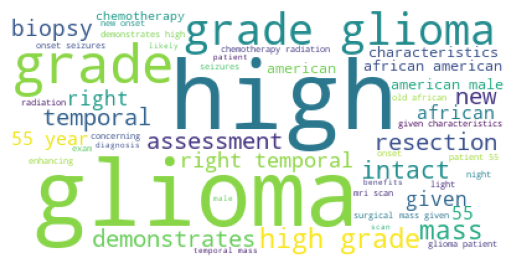

In [320]:
pred_word_cloud(gt_trancripts.tolist(),stop_words=stop_words+get_keywords(gt_trancripts=gt_trancripts_))

## LIME test ??

In [349]:
for el in input_df.transcription:
    if type(el) != str:
        type(el)


In [337]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371 entries, 3425 to 2554
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   transcription      371 non-null    object
 1   medical_specialty  371 non-null    object
dtypes: object(2)
memory usage: 16.8+ KB


In [362]:
wrapped_data.df[:2]

,transcription,medical_specialty
3425,"REASON FOR THE CONSULT:, Nonhealing right ank...",General Medicine
2855,"PREOPERATIVE DIAGNOSIS: , Low back pain.,POSTO...",Neurology


In [364]:
wrapped_data.df.reset_index(drop=True, inplace=True)

In [365]:
wrapped_data.df

,transcription,medical_specialty
0,"REASON FOR THE CONSULT:, Nonhealing right ank...",General Medicine
1,"PREOPERATIVE DIAGNOSIS: , Low back pain.,POSTO...",Neurology
2,"PREOPERATIVE DIAGNOSIS: ,Carcinoma of the pro...",Urology
3,"CURRENT HISTORY:, A 94-year-old female from t...",General Medicine
4,"PREOPERATIVE DIAGNOSIS: , Adenoid hypertrophy....",ENT - Otolaryngology
...,...,...
366,"PREOPERATIVE DIAGNOSIS: , Intrauterine pregnan...",Obstetrics / Gynecology
367,"FINAL DIAGNOSES:,1. Herniated nucleuses pulpo...",Neurosurgery
368,"PREOPERATIVE DIAGNOSIS:, Desire for sterility...",Urology
369,"SUBJECTIVE:, The patient is here for a follow...",SOAP / Chart / Progress Notes


In [368]:
from giskard.models.model_explanation import explain_text
input_df = wrapped_data.df.dropna()
input_df["transcription"].astype(str)
explain_text(
        model=wrapped_model, input_df=input_df, text_column="transcription", text_document=wrapped_data.df["transcription"].iloc[1]
    )



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
--- Logging error ---
Traceback (most recent call last):
  File "/Users/mathieuroques/PycharmProjects/giskard/python-client/.venv/lib/python3.10/site-packages/giskard/models/model_explanation.py", line 71, in explain_text
    shap_values = text_explainer(pd.Series([text_document]))
  File "/Users/mathieuroques/PycharmProjects/giskard/python-client/.venv/lib/python3.10/site-packages/shap/explainers/_partition.py", line 128, in __call__
    return super().__call__(
  File "/Users/mathieuroques/PycharmProjects/giskard/python-client/.venv/lib/python3.10/site-packages/shap/explainers/_explainer.py", line 264, in __call__
    row_result = self.explain_row(
  File "/Users/mathieuroques/PycharmProjects/giskard/python-client/.venv/lib/python3.10/site-packages/shap/explainers/_partition.py", line 153, in explain_row
    self._curr_base_value = fm(m00.reshape(1, -1), zero_index=0)

Exception: Failed to create text explanation

In [321]:
wrapped_data.df

,transcription,medical_specialty
3425,"REASON FOR THE CONSULT:, Nonhealing right ank...",General Medicine
2855,"PREOPERATIVE DIAGNOSIS: , Low back pain.,POSTO...",Neurology
155,"PREOPERATIVE DIAGNOSIS: ,Carcinoma of the pro...",Urology
3419,"CURRENT HISTORY:, A 94-year-old female from t...",General Medicine
3781,"PREOPERATIVE DIAGNOSIS: , Adenoid hypertrophy....",ENT - Otolaryngology
...,...,...
2562,"PREOPERATIVE DIAGNOSIS: , Intrauterine pregnan...",Obstetrics / Gynecology
2733,"FINAL DIAGNOSES:,1. Herniated nucleuses pulpo...",Neurosurgery
29,"PREOPERATIVE DIAGNOSIS:, Desire for sterility...",Urology
1313,"SUBJECTIVE:, The patient is here for a follow...",SOAP / Chart / Progress Notes


In [322]:
wrapped_data.df[wrapped_data.df.medical_specialty=="Neurology"]

,transcription,medical_specialty
2855,"PREOPERATIVE DIAGNOSIS: , Low back pain.,POSTO...",Neurology
2794,"REASON FOR CONSULT:, Organic brain syndrome i...",Neurology
2770,"SUBJECTIVE: , The patient is a 55-year-old Afr...",Neurology
2882,"PREOPERATIVE DIAGNOSES:,1. Epidural hematoma,...",Neurology
2861,"CC: ,RLE weakness.,HX: ,This 42y/o RHM was fou...",Neurology
2765,"PREOPERATIVE DIAGNOSIS:, Rule out temporal ar...",Neurology
2797,"REASON FOR NEUROLOGICAL CONSULTATION:, Muscle...",Neurology
2900,"IMPRESSION:, Abnormal electroencephalogram re...",Neurology
2865,"CHIEF COMPLAINT:, Intractable epilepsy, here ...",Neurology
2764,"PREOPERATIVE DIAGNOSIS:, Headaches, question ...",Neurology
